# Problem 1

Use `kerastuner` to optimize your `readNet` neural network even further. For that, expand the `modelBuilder`
function provided in the lecture notebook by a `hyper.Boolean(label)` hyperparameter that adds a second
dense layer to the network depending whether it’s set to `True` or `False`. For that, create your model
incrementally, starting with an empty model and adding layers using the `add` method:

```py
model = keras.Sequential()
model.add(layers.Dense(2, activation ="relu"))
```

Use your boolean hyperparameter in an if-else-clause or a conditional assignment to add a second layer
depending on the current value of the hyperparameter.

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

2024-01-17 12:19:08.472372: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 12:19:08.616648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 12:19:08.616679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 12:19:08.618624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 12:19:08.623468: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-17 12:19:08.624767: I tensorflow/core/platform/cpu_feature_guard.cc:1

A second `Dense` layer with a `softmax` activation function is added to the model in the `modelBuilder` if the `hyper.Boolean(label)` hyperparameter is set to `True`.

In [2]:
# 1.
def modelBuilder(hyper):
    # Define tunable hyperparameter objects
    hyperNodes = hyper.Int('nodes', min_value=32, max_value=512, step=16)
    hyperLrate = hyper.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
    add_second_layer = hyper.Boolean('add_second_layer', default=False)
    
    model = keras.Sequential([
        keras.layers.Conv2D(96, (6, 6), activation='relu', input_shape=(128,128,3)),
        keras.layers.MaxPooling2D(pool_size=(3,3)),
        keras.layers.Flatten(),
        keras.layers.Dense(units=hyperNodes, activation='relu')])
    
    if add_second_layer:
        keras.layers.Dense(2, activation='softmax')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hyperLrate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    return model

# Problem 2

`galaxyNet` suffers from its rather small training data set. Use the image augmentation technique shown in
the lecture to expand the number of galaxies that it’s exposed to. Are you able to get to an accuracy beyond
90%? Create a confusion matrix to identify if the network prefers a certain type of galaxy.


---------------------------------------------------------------------------------------------------------------------


In this task `keras.preprocessing.image.ImageDataGenerator` is used to augment the image data from `galaxyNet` before training as that increases our training data. The increase in training data would help the model learn better, and increase its accuracy on validation data.

In [3]:
# 2.
import numpy as np

In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

The `get_and_save_data_and_labels` function is used to get `galaxyNet`'s image data and store it into `.npy` files.

In [5]:
from PIL import Image
import os

def get_and_save_data_and_labels(path):
    data = open(path,"r")

    names = []
    types = []

    for line in data:
        fields = line.split(" ")
        names.append( fields[0] )
        types.append( fields[1] )
        
    nData = len(names)
    imgSize = 128
    galaxies = np.zeros((nData,imgSize,imgSize,3))
    labels = np.zeros(nData, dtype='int')

    for i in range(nData):
        filename = "/mnt/share/nnds/galaxies/png/"+str(names[i])+".png"
        img = Image.open(filename)

        imgResized = img.resize(size=(imgSize,imgSize))
        imgArr = np.array(imgResized)

        imgArr = imgArr/255.
        
        galaxies[i,:,:,:] = imgArr 
        labels[i] = types[i]
    
    split = 955

    train_data = galaxies[:split,:,:,:]
    train_labels = labels[:split]

    test_data = galaxies[split+1:nData-1,:,:,:]
    test_labels = labels[split+1:nData-1]
    
    os.makedirs("galaxies")
    np.save("galaxies/trainGalaxies.npy", train_data)
    np.save("galaxies/trainLabels.npy", train_labels)

    np.save("galaxies/testGalaxies.npy", test_data)
    np.save("galaxies/testLabels.npy", test_labels)
        
    return train_data, train_labels, test_data, test_labels

The `load_train_and_test_data` is used to reload the `galaxyNet` data quickly.

In [6]:
def load_train_and_test_data():
    train_data = np.load("galaxies/trainGalaxies.npy")
    train_labels = np.load("galaxies/trainLabels.npy")

    test_data = np.load("galaxies/testGalaxies.npy")
    test_labels = np.load("galaxies/testLabels.npy")
    
    return train_data, train_labels, test_data, test_labels

In [7]:
train_data, train_labels, test_data, test_labels = load_train_and_test_data()

Here `kerastuner` is used to find the optimal hyperparameters for the dataset along with the `modelBuilder` class, and then build the model.

In [9]:
folder = "galaxyNet02"

nEpochs = 20
tuner = kt.Hyperband(modelBuilder,objective='val_accuracy',
                     max_epochs=nEpochs,factor=3,
                     directory=folder,
                     project_name="galaxyNet02")

2024-01-17 12:19:45.779349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 12:19:45.779640: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
# Getting optimal hyperparameters
# batch_size = len(train_data) 

# # data_train_aug = []
# # labels_train_aug = []

# # for data, labels in datagen.flow(train_data, train_labels, batch_size=batch_size, shuffle=False):
# #     data_train_aug = data
# #     labels_train_aug = labels
# #     break
    
# # data_train_combined = np.concatenate((train_data, data_train_aug))
# # data_labels_combined = np.concatenate((train_labels, labels_train_aug))

# # np.save("galaxies/data_train_combined.npy", data_train_combined)
# # np.save("galaxies/data_labels_combined.npy", data_labels_combined)

data_train_combined = np.load("galaxies/trainGalaxies.npy")
data_labels_combined = np.load("galaxies/trainLabels.npy")

# tuner.search(data_train_combined, data_labels_combined, 
#              epochs=nEpochs, 
#              validation_data=(test_data, test_labels), 
#              verbose=1)
hyperBest = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
print("Optimal hyperparameters:")
for key in hyperBest.values:
    print(key, hyperBest.values[key])

Optimal hyperparameters:
nodes 240
learning_rate 1e-05
add_second_layer False
tuner/epochs 20
tuner/initial_epoch 7
tuner/bracket 2
tuner/round 2
tuner/trial_id 0012


Training with the optimal number epochs ...

In [22]:
#from keras.models import load_model

nEpochs = 20
model = tuner.hypermodel.build(hyperBest)
#model = load_model('galaxyNet02/galaxyNet02/trial_0012/checkpoint')
history = model.fit(data_train_combined, data_labels_combined, 
                    validation_data=(test_data, test_labels), 
                    initial_epoch=1,
                    epochs=nEpochs,
                    verbose=1)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 2/20
30/30 [==============================] - 10s 324ms/step - loss: 1.5872 - accuracy: 0.4545 - val_loss: 1.0253 - val_accuracy: 0.5042
Epoch 3/20
30/30 [==============================] - 10s 321ms/step - loss: 0.9851 - accuracy: 0.5393 - val_loss: 0.9994 - val_accuracy: 0.5042
Epoch 4/20
30/30 [==============================] - 10s 319ms/step - loss: 0.9473 - accuracy: 0.5393 - val_loss: 0.9660 - val_accuracy: 0.5042
Epoch 5/20
30/30 [==============================] - 10s 319ms/step - loss: 0.8922 - accuracy: 0.5393 - val_loss: 0.9033 - val_accuracy: 0.5042
Epoch 6/20
30/30 [==============================] - 10s 323ms/step - loss: 0.8130 - accuracy: 0.5393 - val_loss: 0.7900 - val_accuracy: 0.5042
Epoch 7/20
30/30 [==============================] - 10s 320ms/step - loss: 0.7092 - accuracy: 0.6440 - val_loss: 0.8402 - val_accuracy: 0.6471
Epoch 8/20
30/30 [==============================] - 10s 321ms/step - loss: 0.9057 - accuracy: 0.6251 - val_loss: 0.8614 - val_accuracy: 0.5798

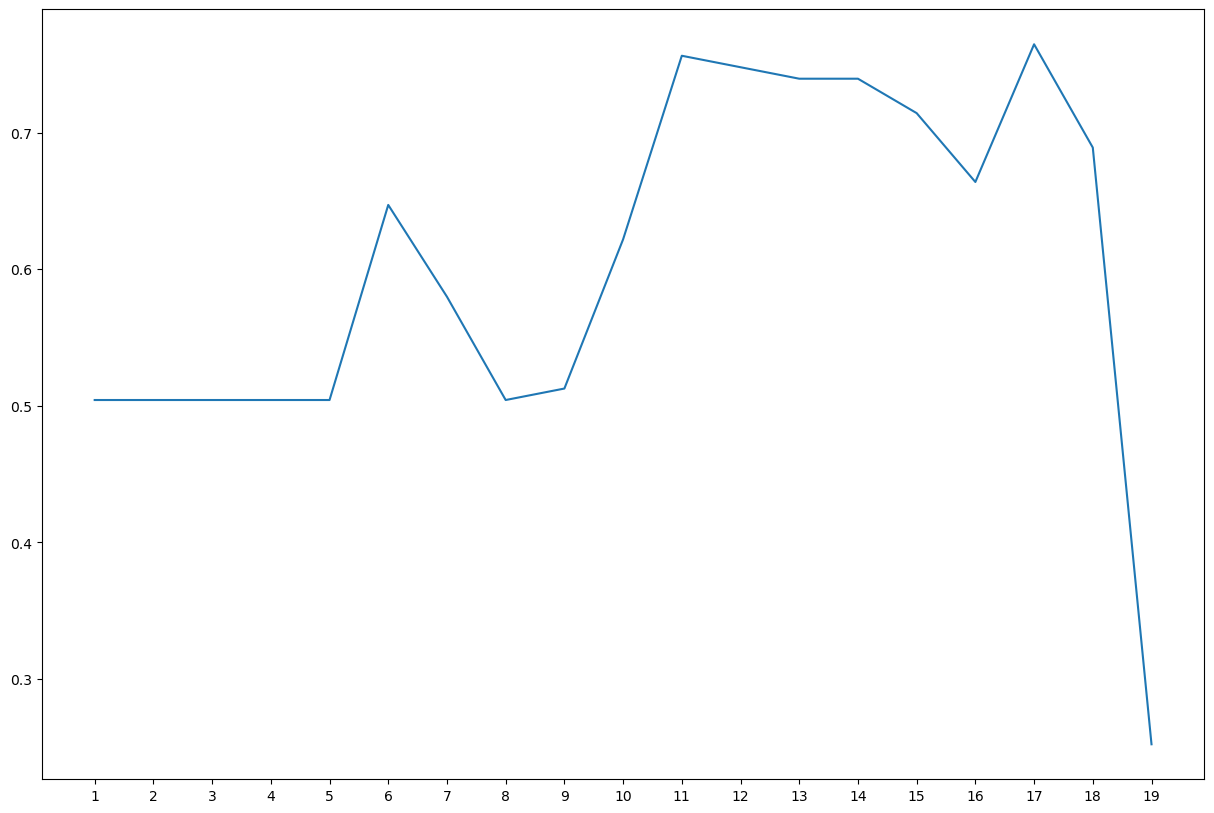

In [25]:
import matplotlib.pyplot as plt

valAccEvo = history.history['val_accuracy']
i = list(range(1,nEpochs))

plt.figure(figsize=(15,10))
plt.plot(i,valAccEvo)
plt.xticks(i)
plt.show()

Making a confusion matrix to see if netwrok is biased ...

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test_data)
pred_classes = np.argmax(pred, axis=1)

conf_matrix = confusion_matrix(test_labels, pred_classes)
class_report = classification_report(test_labels, pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

4/4 [==============================] - 0s 37ms/step
Confusion Matrix:
[[30  0  0]
 [60  0  0]
 [29  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        30
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00        29

    accuracy                           0.25       119
   macro avg       0.08      0.33      0.13       119
weighted avg       0.06      0.25      0.10       119



/home/nnds6b/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nnds6b/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nnds6b/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From this we can see currently that ...

- Class 0 has 30 true positives (correctly predicted), and 0 false positives (incorrectly predicted as class 1 or class 2).
- Class 1 has 0 true positives and 60 false positives.
- Class 2 has 0 true positives and 29 false positives

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. Precision is high for class 0 (0.25), but it's 0 for classes 1 and 2, indicating a high rate of false positives.
- **Recall**: The ratio of correctly predicted positive observations to the total actual positives. Recall is 1.0 for class 0, but 0 for classes 1 and 2, indicating that the model is missing a significant number of positive instances.
- **F1-score**: The weighted average of precision and recall. It considers both false positives and false negatives. The F1-score is low for all classes.
- **Support**: The number of actual occurrences of the class in the specified dataset.

### Accuracy:
The overall accuracy of the model is 0.25, indicating that the model is not performing well.
Macro and Weighted Averages:

The macro average calculates metrics independently for each class and then takes the average. The macro average F1-score is 0.13.
The weighted average considers the number of samples for each class. The weighted average F1-score is 0.10.

### Summary:
The model is struggling to correctly classify classes 1 and 2, resulting in poor precision, recall, and F1-scores.
The low accuracy suggests that the model's overall performance is not satisfactory.

Traininig up to the best epoch ...

In [47]:
model = tuner.hypermodel.build(hyperBest)

# Retrain the model
history = model.fit(data_train_combined, data_labels_combined, 
                    validation_data=(test_data, test_labels),
                    initial_epoch=1,
                    epochs=best_epoch,
                    verbose=1)

Epoch 2/17
30/30 [==============================] - 10s 321ms/step - loss: 1.3609 - accuracy: 0.4429 - val_loss: 0.9941 - val_accuracy: 0.5042
Epoch 3/17
30/30 [==============================] - 10s 320ms/step - loss: 0.9217 - accuracy: 0.5393 - val_loss: 0.9148 - val_accuracy: 0.5042
Epoch 4/17
30/30 [==============================] - 10s 320ms/step - loss: 0.8166 - accuracy: 0.5393 - val_loss: 0.8233 - val_accuracy: 0.5042
Epoch 5/17
30/30 [==============================] - 10s 321ms/step - loss: 0.7246 - accuracy: 0.5466 - val_loss: 0.7091 - val_accuracy: 0.5294
Epoch 6/17
30/30 [==============================] - 10s 320ms/step - loss: 0.6496 - accuracy: 0.7351 - val_loss: 1.1196 - val_accuracy: 0.7143
Epoch 7/17
30/30 [==============================] - 10s 319ms/step - loss: 4.2004 - accuracy: 0.3853 - val_loss: 5.4806 - val_accuracy: 0.2521
Epoch 8/17
30/30 [==============================] - 10s 319ms/step - loss: 5.3946 - accuracy: 0.2492 - val_loss: 5.4806 - val_accuracy: 0.2521

KeyboardInterrupt: 

Checking the network's perfomance ...

In [ ]:
import matplotlib.pyplot as plt

valAccEvo = history.history['val_accuracy']
i = list(range(1,nEpochs))

plt.figure(figsize=(15,10))
plt.plot(i,valAccEvo)
plt.xticks(i)
plt.show()